0.71,1.41,2.12,2.83,3.54,4.24,4.95,5.66,6.36,7.07,

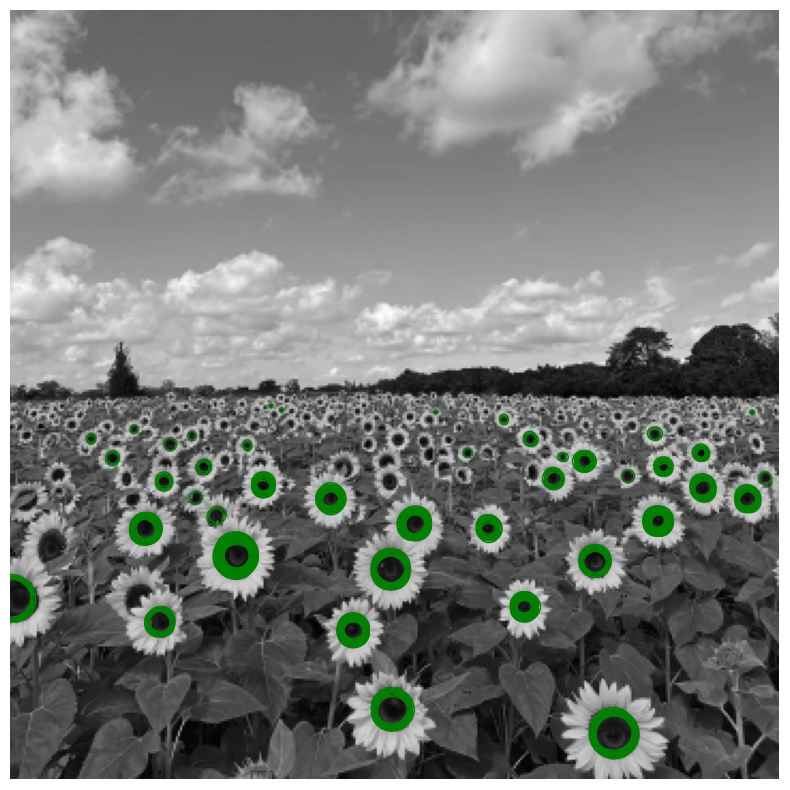

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load the image and convert it to grayscale and normalizes pixel values to range [0, 1]
img = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY) / 255

# Display the grayscale image with detected circles
plt.figure(figsize=(10, 10), frameon=False)
plt.imshow(gray, cmap='gray')
plt.axis('off')

# Get the current axes of the plot to add patches on top of the image.
ax = plt.gca()

patches = []

# Detect blobs at different sigma values
for r in range(1, 11):
    sigma = r / 1.414
    print(f"{sigma:.2f}", end=",")
    hw = round(3 * sigma)  # Half width of the kernel
    X, Y = np.meshgrid(np.arange(-hw, hw + 1, 1), np.arange(-hw, hw + 1, 1))

    # Calculate Laplacian of Gaussian (LoG) filter
    LOG = ((X**2 + Y**2) / (2 * sigma**2) - 1) * np.exp(-(X**2 + Y**2) / (2 * sigma**2)) / (np.pi * sigma**4)

    # Scale the filter and apply it to the image
    LOG = sigma**2 * LOG
    img_log = np.square(cv.filter2D(gray, -1, LOG))

    # Detect maxima manually
    coordinates = []
    (H, W) = img_log.shape
    k = 1  # Neighborhood size
    threshold = 0.1  # Threshold for maxima detection
    for i in range(k, H - k):
        for j in range(k, W - k):
            slice_img = img_log[i - k:i + k + 1, j - k:j + k + 1]
            if np.max(slice_img) >= threshold:
                # Get coordinates of the maximum point
                x, y = np.unravel_index(slice_img.argmax(), slice_img.shape)
                coordinates.append((i + x - k, j + y - k))
    coordinates = set(coordinates)

    # Plot circles around detected blobs
    for x, y in coordinates:
        c = plt.Circle((y, x), sigma * 1.414, color='g', linewidth=1, fill=False)
        ax.add_patch(c)
    patches.append(c)
    ax.plot()

ax.set_xlim([0, img.shape[1]])
ax.set_ylim([img.shape[0], 0])

# Add legend and title
plt.axis('off')
plt.show()

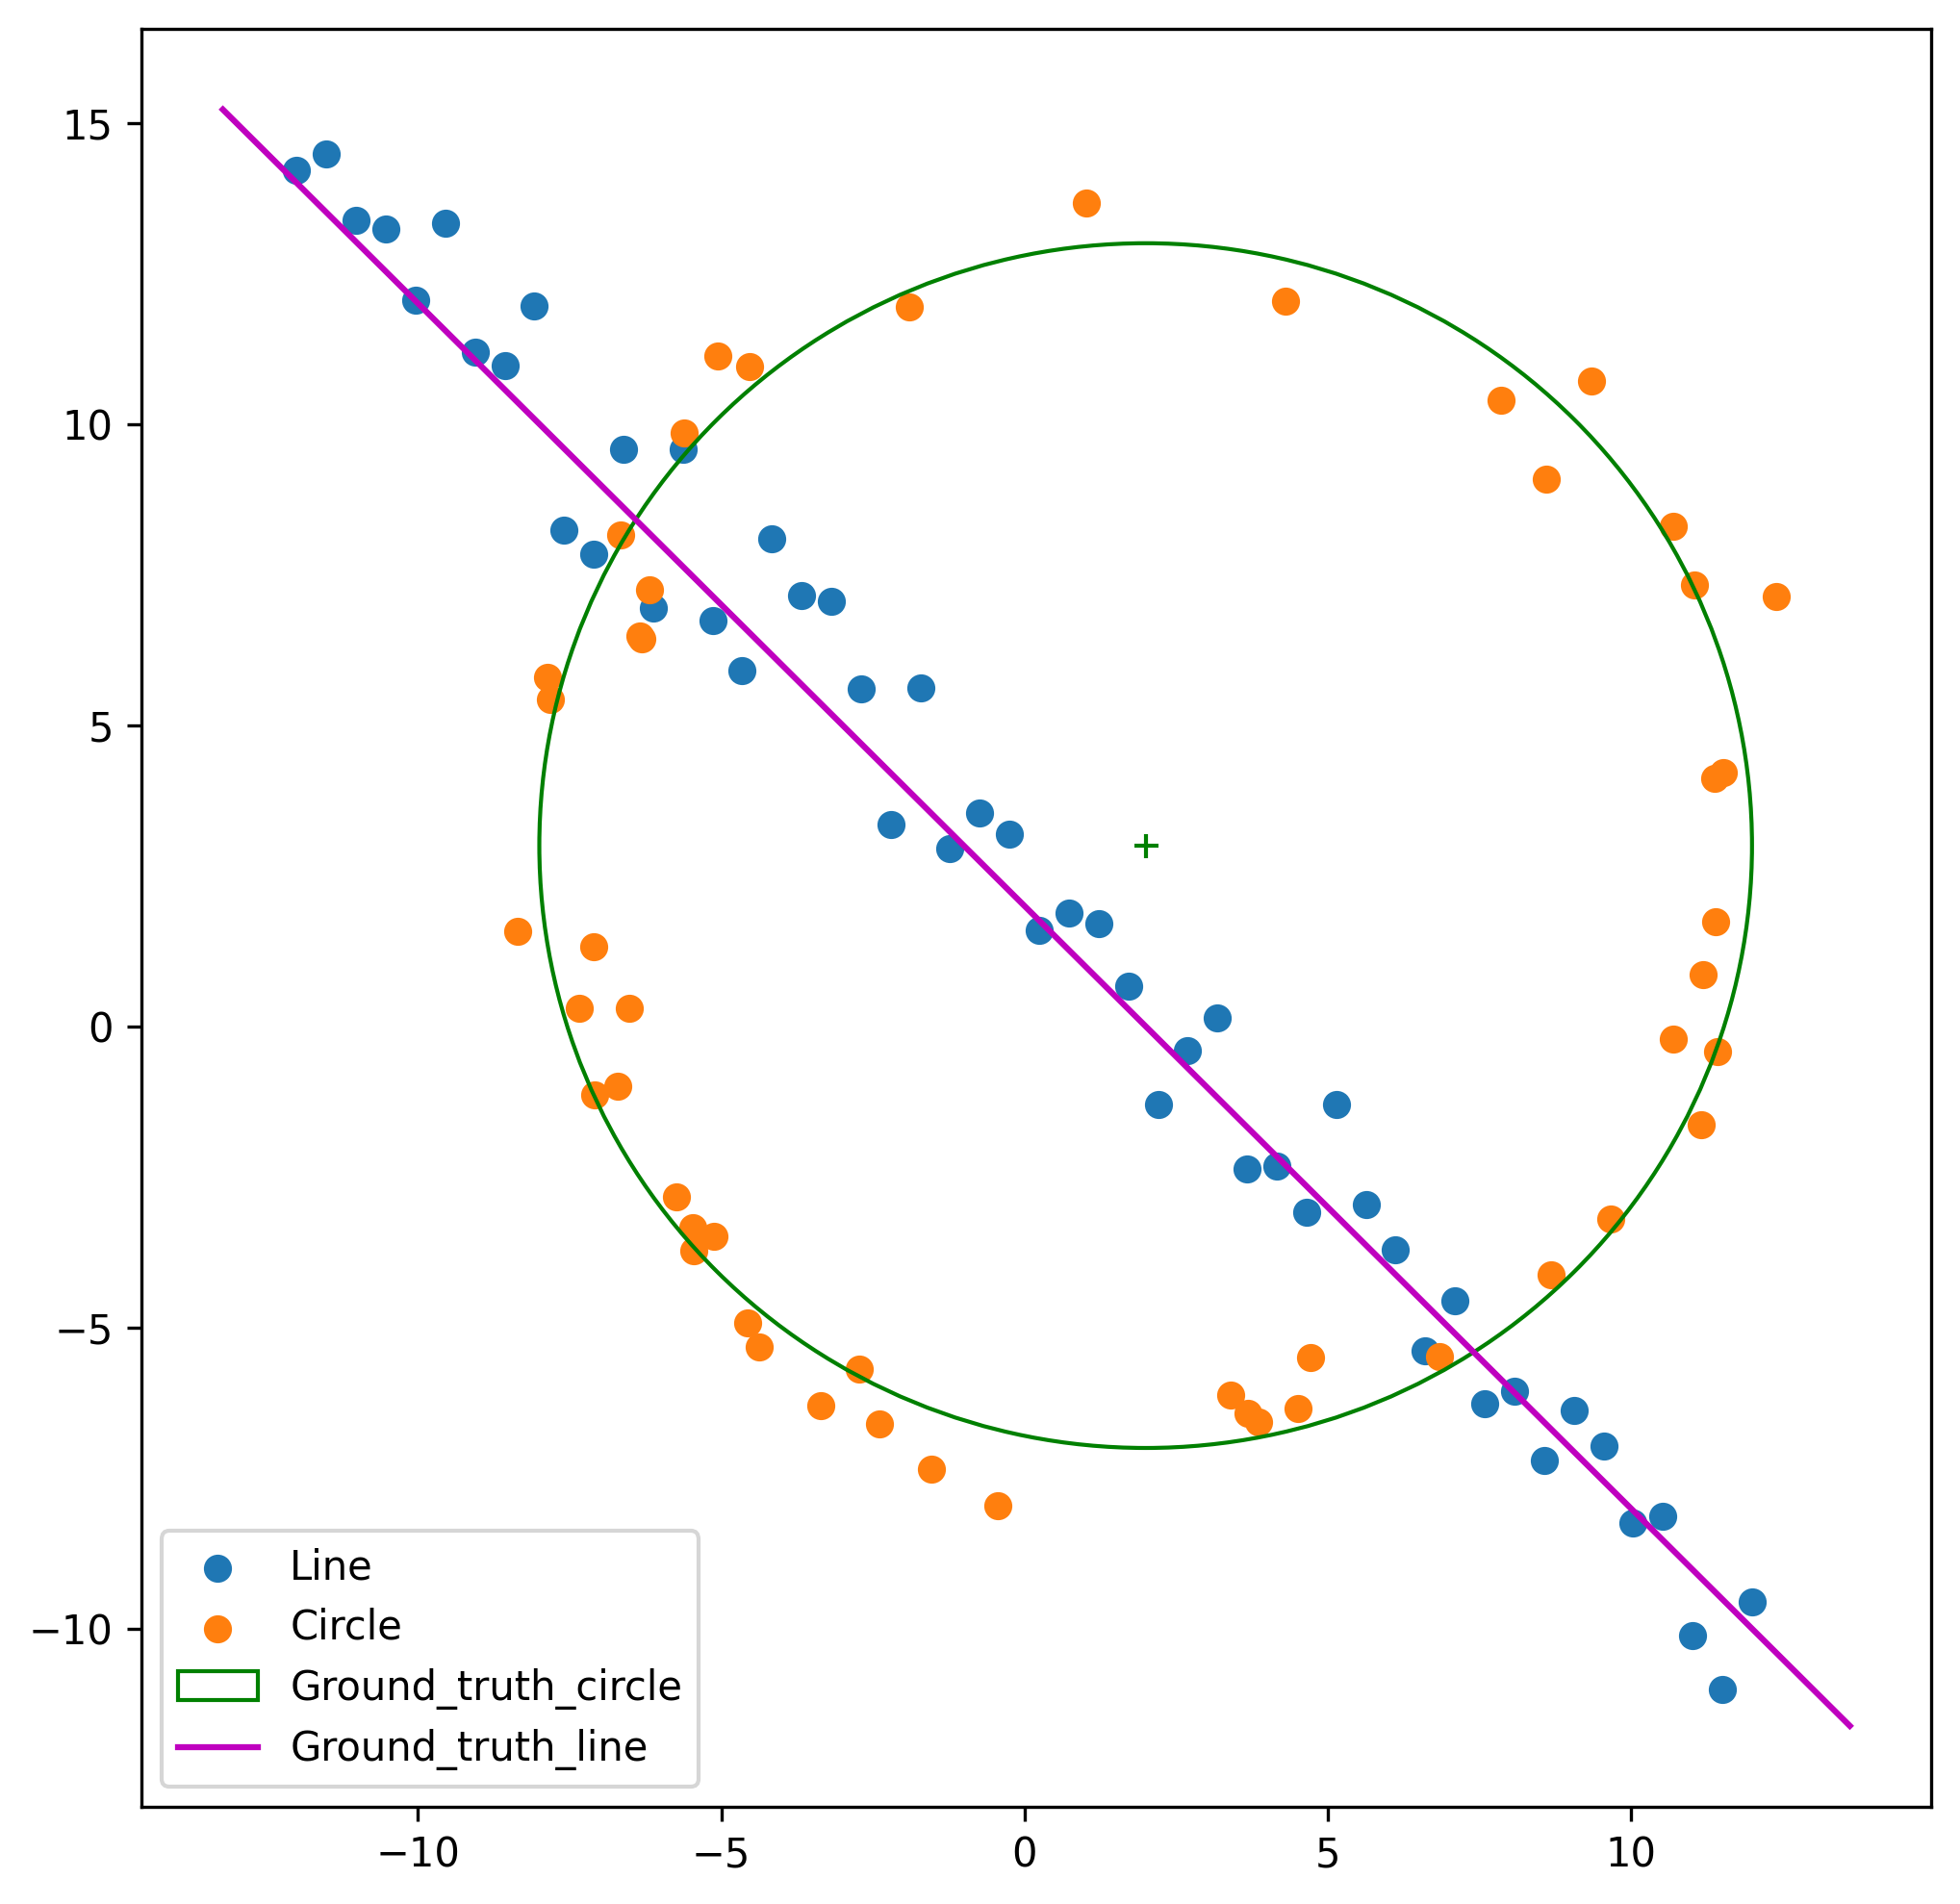

In [ ]:
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)
N = 100
half_n = N//2

r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r/16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s*np.random.randn(half_n)
x, y = x0_gt + (r + n)*np.cos(t), y0_gt + (r + n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n,1), y.reshape(half_n,1)))
s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n,1), y.reshape(half_n,1)))
X = np.vstack((X_circ, X_line))  # All points

fig, ax = plt.subplots(1,1, figsize=(8,8), dpi=300)
ax.scatter(X_line[:,0], X_line[:,1], label='Line')
ax.scatter(X_circ[:,0], X_circ[:,1], label='Circle')
circle_gt = plt.Circle((x0_gt,y0_gt), r, color='g', fill=False, label='Ground_truth_circle')
ax.add_patch(circle_gt)
ax.plot((x0_gt), (y0_gt), '+', color='g')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground_truth_line')
plt.legend()





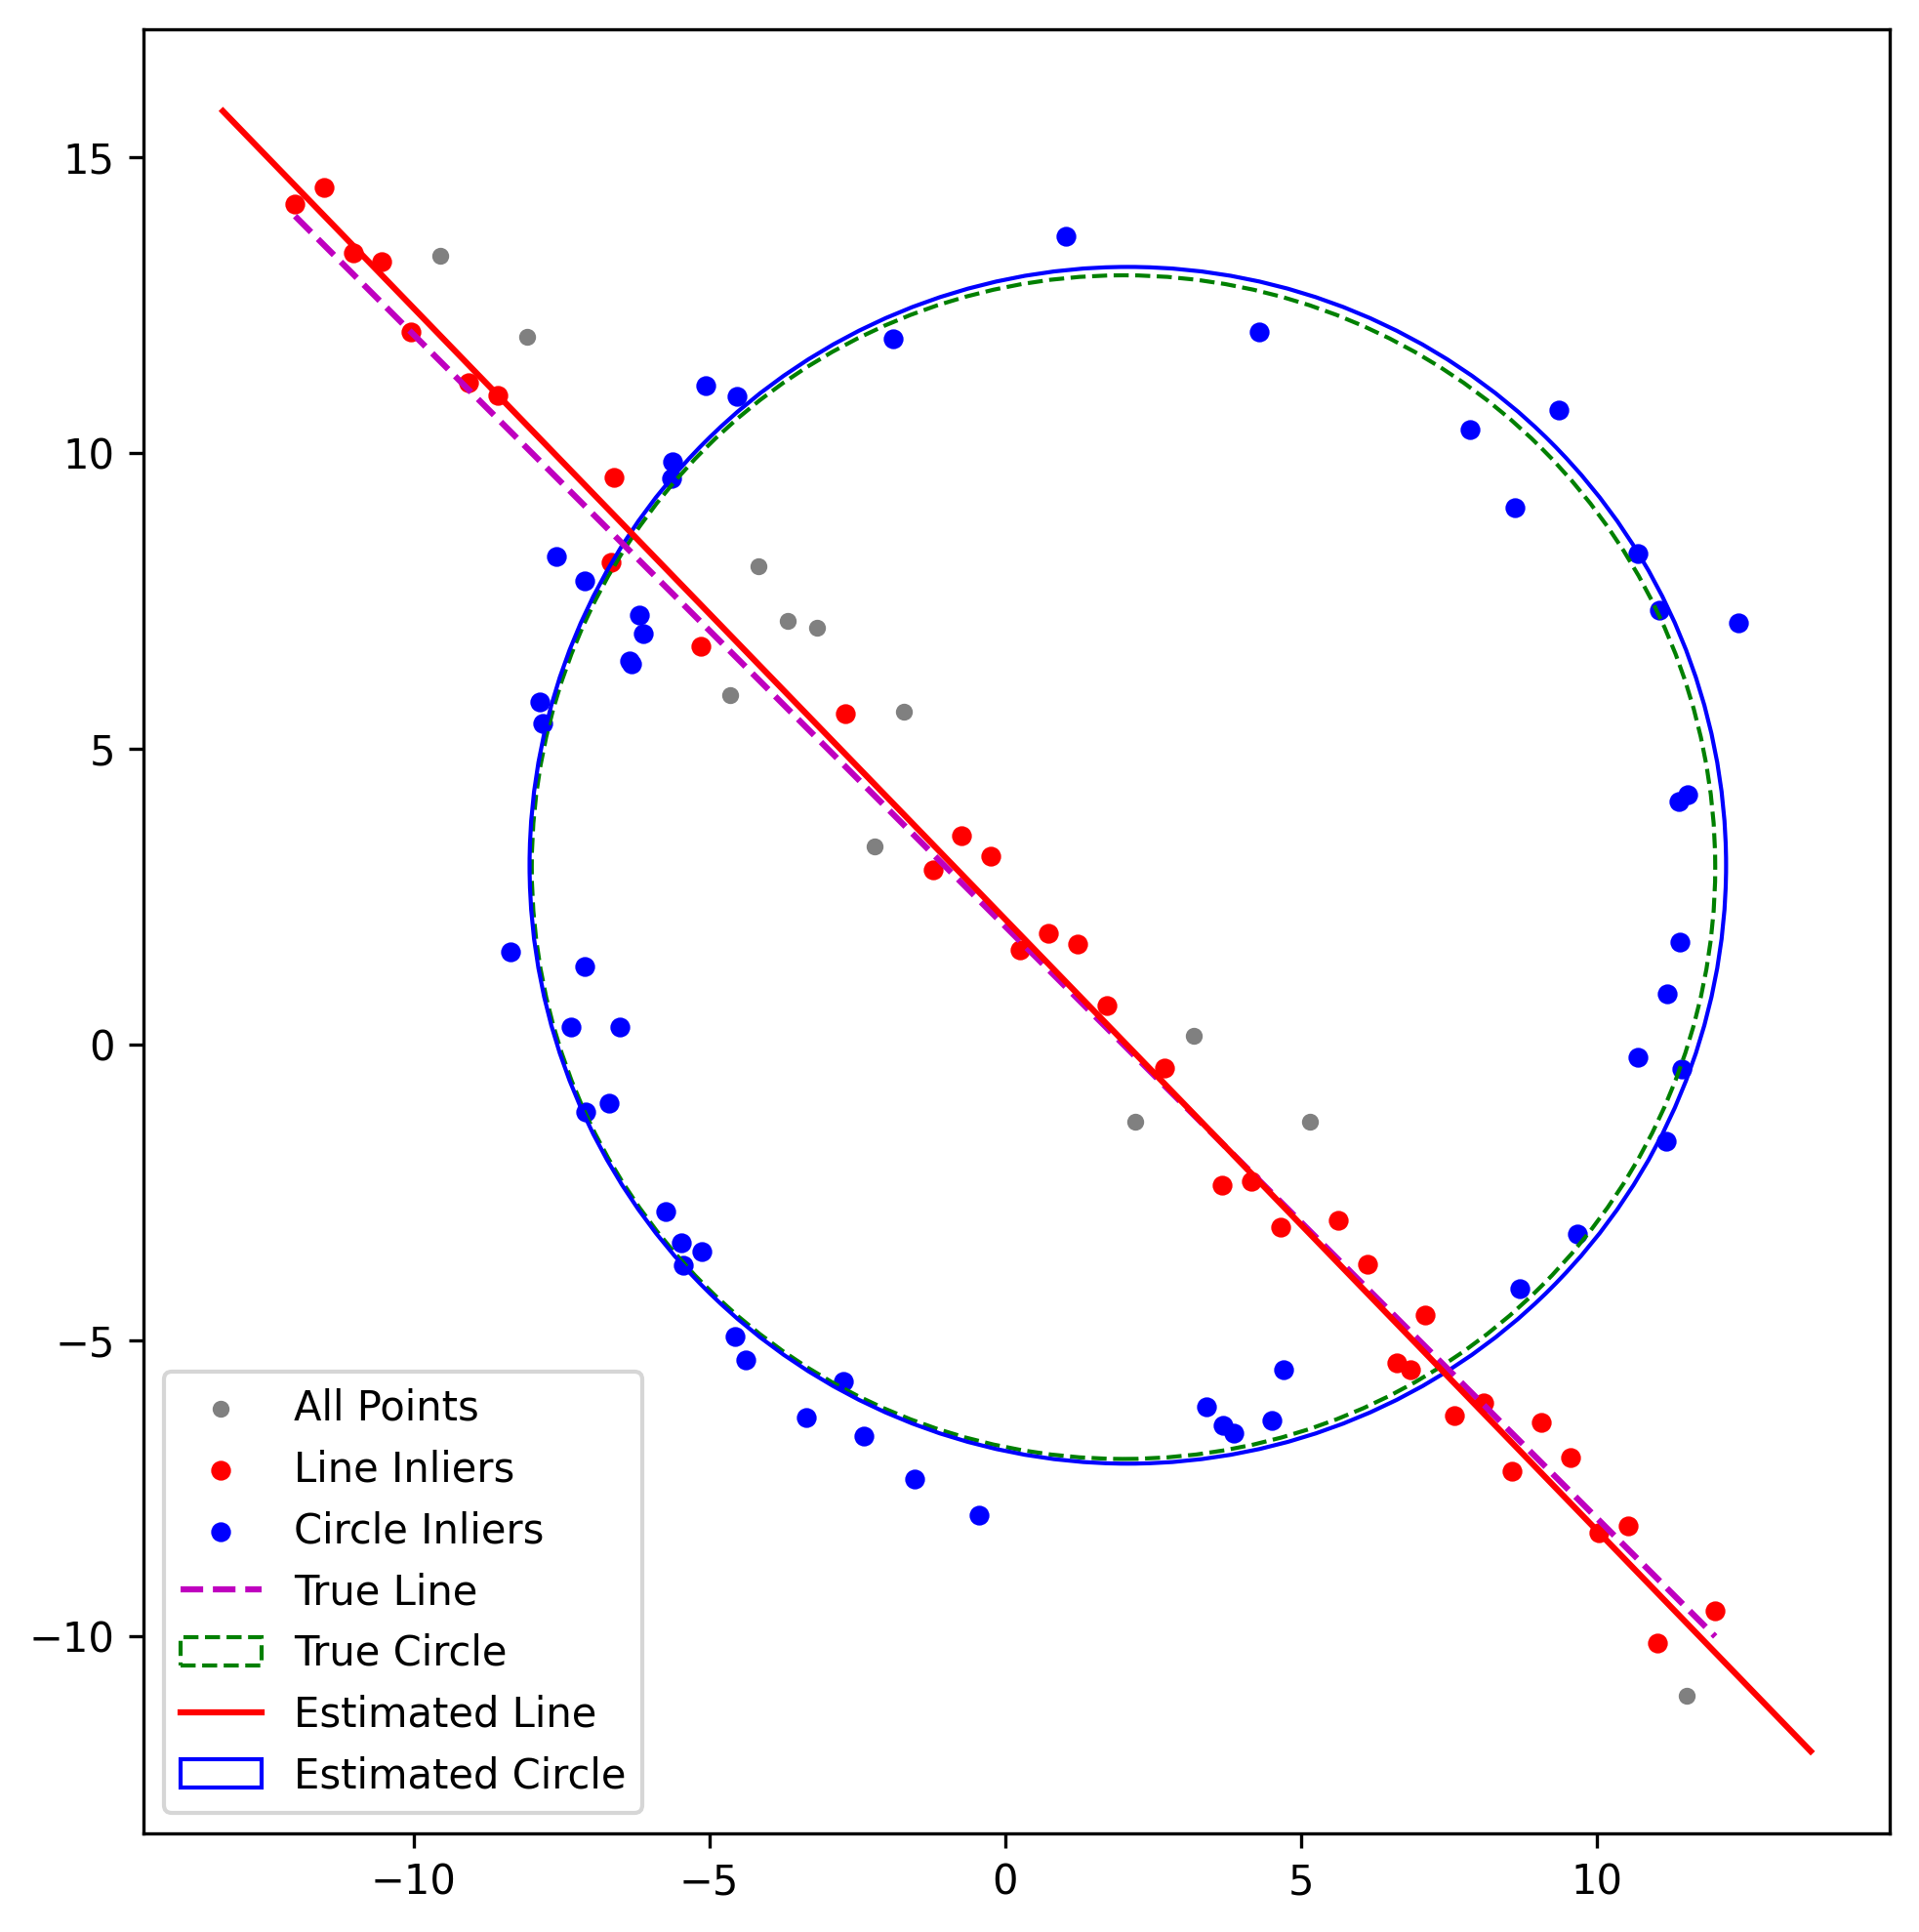

Line params (a,b,d): (np.float64(-0.7184192033652615), np.float64(-0.6956104141227495), np.float64(1.4753449080312475))
Circle params (x0,y0,r): (np.float64(2.0732016632652637), np.float64(3.0311482687200946), np.float64(10.11033486610821))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Utility functions

def compute_point_line_dist(line_params, points):
    a, b, d = line_params
    denom = np.sqrt(a**2 + b**2)
    return np.abs(a*points[:,0] + b*points[:,1] + d) / denom

def fit_line_from_two_pts(p1, p2):
    a = p2[1] - p1[1]
    b = p1[0] - p2[0]
    d = -(a*p1[0] + b*p1[1])
    norm = np.sqrt(a**2 + b**2)
    return a/norm, b/norm, d/norm

def estimate_circle_from_pts(pts):
    A = np.array([
        [pts[0,0], pts[0,1], 1],
        [pts[1,0], pts[1,1], 1],
        [pts[2,0], pts[2,1], 1]
    ])
    B = -np.array([
        [pts[0,0]**2 + pts[0,1]**2],
        [pts[1,0]**2 + pts[1,1]**2],
        [pts[2,0]**2 + pts[2,1]**2]
    ])
    sol = np.linalg.solve(A, B)
    xc, yc = -0.5*sol[0,0], -0.5*sol[1,0]
    r = np.sqrt(xc**2 + yc**2 - sol[2,0])
    return xc, yc, r

def radial_error(circle_params, points):
    x0, y0, r = circle_params
    dist_to_center = np.sqrt((points[:,0]-x0)**2 + (points[:,1]-y0)**2)
    return np.abs(dist_to_center - r)


def ransac_line_fit(points, max_iter=1000, eps=0.6, min_support=35):
    best_model = None
    best_inliers = np.empty((0,2))
    n_pts = len(points)

    for _ in range(max_iter):
        idx = np.random.choice(n_pts, 2, replace=False)
        line_params = fit_line_from_two_pts(points[idx[0]], points[idx[1]])
        dist = compute_point_line_dist(line_params, points)
        mask = dist < eps
        if mask.sum() > len(best_inliers) and mask.sum() >= min_support:
            best_model = line_params
            best_inliers = points[mask]
    return best_model, best_inliers

def ransac_circle_fit(points, max_iter=1000, eps=1.5, min_support=45):
    best_model = None
    best_inliers = np.empty((0,2))
    n_pts = len(points)

    for _ in range(max_iter):
        idx = np.random.choice(n_pts, 3, replace=False)
        try:
            circ_params = estimate_circle_from_pts(points[idx])
        except np.linalg.LinAlgError:
            continue
        dist = radial_error(circ_params, points)
        mask = dist < eps
        if mask.sum() > len(best_inliers) and mask.sum() >= min_support:
            best_model = circ_params
            best_inliers = points[mask]
    return best_model, best_inliers


# Fit line then circle on residual points
line_params, line_inliers = ransac_line_fit(X)

# Remove line inliers
mask = np.ones(len(X), dtype=bool)
for pt in line_inliers:
    mask[np.all(np.isclose(X, pt), axis=1)] = False
remaining = X[mask]

circle_params, circle_inliers = ransac_circle_fit(remaining)


# Visualization
fig, ax = plt.subplots(figsize=(8,8), dpi=300)
ax.scatter(X[:,0], X[:,1], c='gray', s=10, label='All Points')
ax.scatter(line_inliers[:,0], line_inliers[:,1], c='red', s=15, label='Line Inliers')
ax.scatter(circle_inliers[:,0], circle_inliers[:,1], c='blue', s=15, label='Circle Inliers')

# Ground truth
xx = np.linspace(-12, 12, 100)
ax.plot(xx, m*xx + b, 'm--', label='True Line')  # ✅ fixed c→b
gt_circle = plt.Circle((x0_gt, y0_gt), r, fill=False, color='green', linestyle='--', label='True Circle')
ax.add_patch(gt_circle)

# Estimated line
a,b_,d = line_params
xx_est = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
yy_est = -(a*xx_est + d)/b_
ax.plot(xx_est, yy_est, 'r', label='Estimated Line')

# Estimated circle
x0, y0, rr = circle_params
est_circle = plt.Circle((x0, y0), rr, fill=False, color='blue', label='Estimated Circle')
ax.add_patch(est_circle)

ax.set_aspect('equal')
ax.legend()
plt.show()

print(f"Line params (a,b,d): {line_params}")
print(f"Circle params (x0,y0,r): {circle_params}")


In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def point_selection(action, x, y, flags, param):
    # Define mouse click occassions to gather point coordinates for warp the image

    global clicked_points

    if action == cv.EVENT_LBUTTONDOWN:
        clicked_points.append((x, y))
        cv.circle(base_img, (x, y), 4, (0, 0, 255), -1)

        # Show the selected positions on the base image in a second window
        # (Simply close this second window and continue point selection in the first window)
        cv.imshow('Image', base_img)

adding_img = cv.imread(r'C:\Users\Sithum\Documents\all_vs_code\Assignment_02\usa.jpg')
base_img = cv.imread(r'C:\Users\Sithum\Documents\all_vs_code\Assignment_02\times.jpg')


# Normalize the pixel values into [0, 1] range
base_img = base_img.astype(np.float32) / np.iinfo(base_img.dtype).max
adding_img = adding_img.astype(np.float32) / np.iinfo(adding_img.dtype).max

# Display the base image to implement point selection step
cv.imshow('Base Image', base_img)
cv.setMouseCallback('Base Image', point_selection)

# Store the clicked points in the image
clicked_points = []

# Point Selection Step
# Select four points in the order of left top, left bottom, right top and right bottom
while len(clicked_points) < 4:
    cv.waitKey(1)
cv.destroyAllWindows()

# Define source and destination points for homography
destination_points = np.array(clicked_points).astype(np.float32)
h2, w2 = adding_img.shape[:2]
source_points = np.float32([[0, 0], [w2, 0], [0, h2], [w2, h2]])

# Define the homographic matrix
H = cv.getPerspectiveTransform(source_points, destination_points)
# Warping the adding image with the homography
warped_img = cv.warpPerspective(adding_img, H, (base_img.shape[1], base_img.shape[0]))
# Superimposing the warped image with the base image
supimp_img = cv.addWeighted(base_img, 1, warped_img, 1, 0)

#region
print("Image shape:", base_img.shape)
print("Flag shape:", adding_img.shape)
print("Selected Points:", clicked_points)
print('Homographic Matrix: ')
print(H)

plt.figure(figsize=(12,6))
plt.imshow(cv.cvtColor(supimp_img, cv.COLOR_BGR2RGB))
plt.title('Image of Times Building Superimposed with the US Army Flag')
#endregion

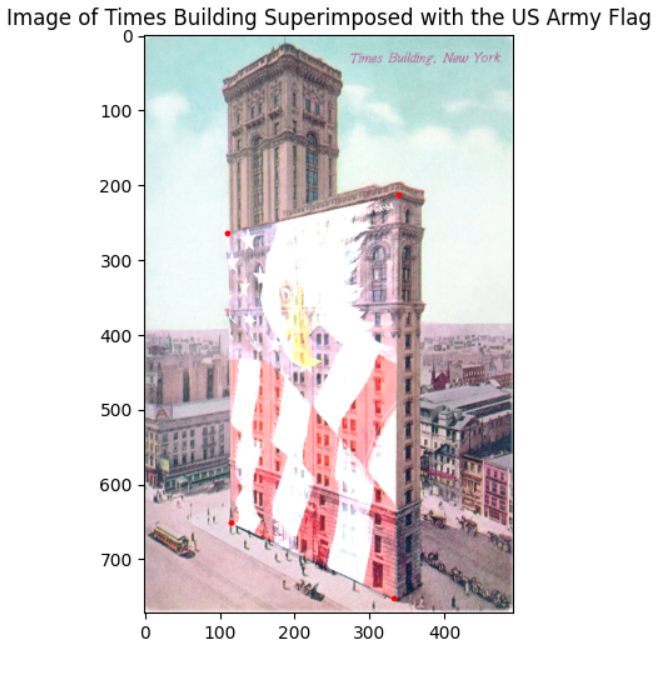

In [ ]:
import cv2 as cv
from google.colab.patches import cv2_imshow
file_path = 'Result_Q3.png'  # replace with your actual path
img = cv.imread(file_path)
cv2_imshow(img)
cv.waitKey(0)
cv.destroyAllWindows()


In [ ]:
from skimage import transform

In [ ]:
def get_sift_features(img1, img2):
    # Convert to grayscale
    img1_gray = cv.cvtColor(img1, cv.COLOR_RGB2GRAY)
    img2_gray = cv.cvtColor(img2, cv.COLOR_RGB2GRAY)

    # Get SIFT descriptors
    sift = cv.SIFT_create(nOctaveLayers = 3,contrastThreshold = 0.09, edgeThreshold = 25, sigma = 1)
    keypoints1, descriptors1 = sift.detectAndCompute(img1_gray, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2_gray, None)

    # Match using Brute Force Matcher
    bf = cv.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    # Lowe's ratio to filter best matches
    best_matches = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            best_matches.append(m)

    return best_matches, keypoints1, keypoints2



(np.float64(-0.5), np.float64(1599.5), np.float64(639.5), np.float64(-0.5))

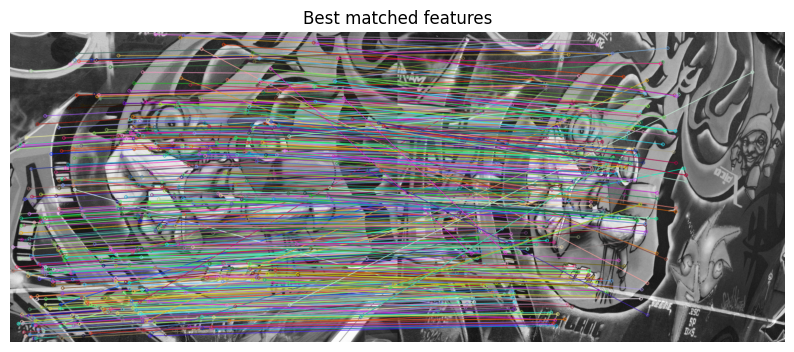

In [ ]:
img1 = cv.imread("img1.ppm")
assert img1 is not None
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)

img5 = cv.imread("img3.ppm")
assert img5 is not None
img5 = cv.cvtColor(img5, cv.COLOR_BGR2RGB)

best_matches, keypoints1, keypoints5 = get_sift_features(img1, img5)

plt.figure(figsize=(10, 10))
matched_img = cv.drawMatches(cv.cvtColor(img1, cv.COLOR_BGR2GRAY), keypoints1, cv.cvtColor(img5, cv.COLOR_BGR2GRAY), keypoints5, best_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(matched_img)
plt.title("Best matched features")
plt.axis('off')

In [ ]:
def get_inliers(src_full, dst_full, tform, thres):
    dst_check = tform(src_full)
    errors = np.sqrt(np.sum(np.square(dst_check - dst_full), axis = 1))

    return np.where(errors < thres)[0]

In [ ]:

def find_best_homography(good_matches, keypoints1, keypoints5):
    # Array of all the matching points
    src_full = []
    dst_full = []

    for match in good_matches:
        src_full.append(np.array(keypoints1[match.queryIdx].pt))
        dst_full.append(np.array(keypoints5[match.trainIdx].pt))

    src_full = np.array(src_full)
    dst_full = np.array(dst_full)

    # RANSAC for finding best homography
    num_points = 4
    thres = 1
    d = 0.5 * len(good_matches)
    iters = 200

    best_homography = None
    best_inlier_count = 0
    best_inliers = None

    for i in range(iters):
        chosen_matches = np.random.choice(good_matches, num_points, replace = False)

        src_points = []
        dst_points = []
        for match in chosen_matches:
            src_points.append(np.array(keypoints1[match.queryIdx].pt))
            dst_points.append(np.array(keypoints5[match.trainIdx].pt))

        src_points = np.array(src_points)
        dst_points = np.array(dst_points)

        tform = transform.estimate_transform('projective', src_points, dst_points)

        inliers = get_inliers(src_full, dst_full, tform, thres)
        #print(f'Iteration {i}: No. of inliers = {len(inliers)}')

        if len(inliers) > best_inlier_count:
            best_inlier_count = len(inliers)
            best_homography = tform
            best_inliers = inliers

    print(f'Best no. of inliers = {best_inlier_count}')
    return best_homography, best_inliers

Best no. of inliers = 140


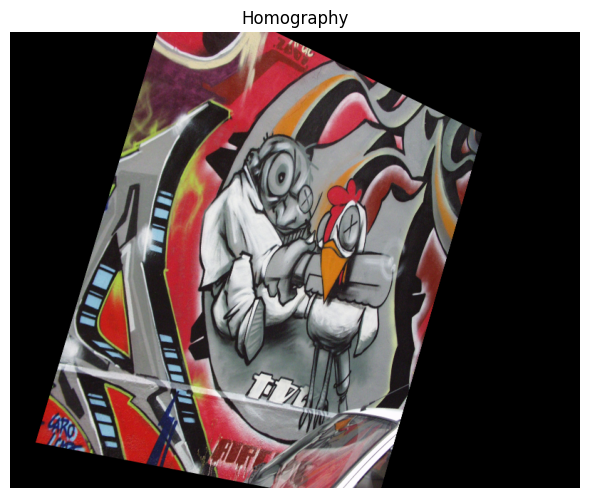

In [ ]:
np.random.seed(62)
pad = 100

final_transform = transform.ProjectiveTransform(np.identity(3))
final_transformed_image = transform.warp(img1, final_transform.inverse)

good_matches, keypoints1, keypoints5 = get_sift_features(img1, img5)
tform, _ = find_best_homography(good_matches, keypoints1, keypoints5)

final_transformed_image = transform.warp(final_transformed_image, tform.inverse)
final_transform = final_transform + tform

plt.figure(figsize = (6, 6))
plt.imshow(final_transformed_image)
plt.title(f"Homography")
plt.axis('off')
plt.tight_layout()

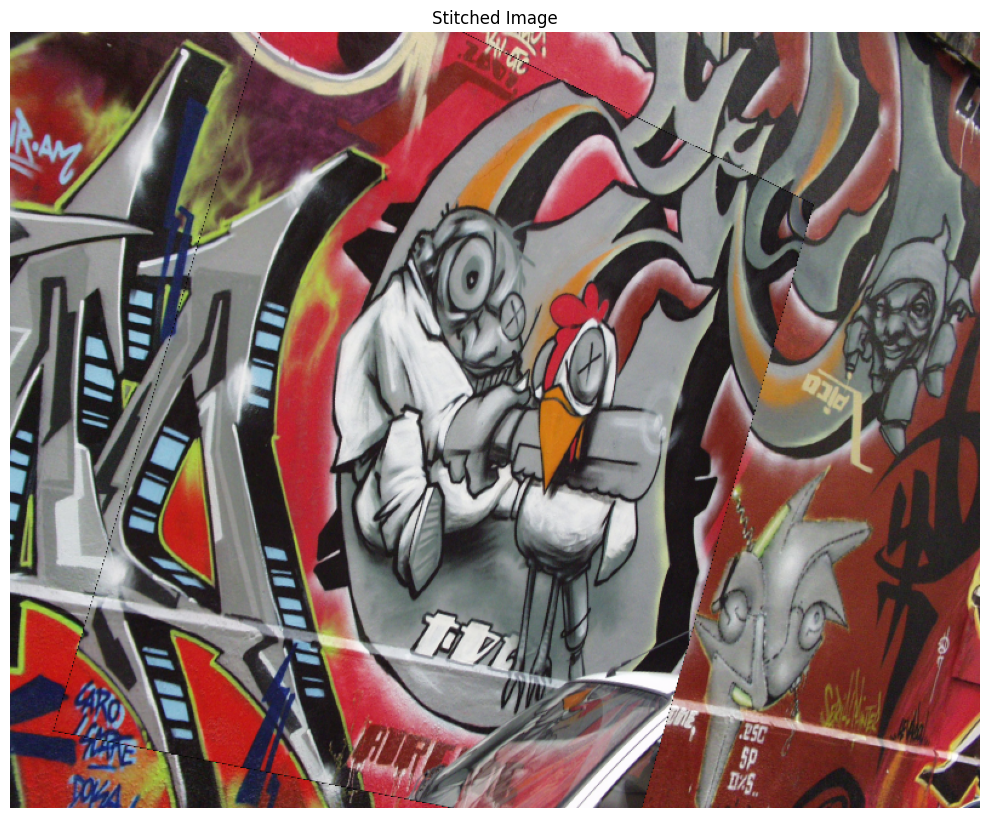

In [ ]:
final_transformed_image = transform.warp(img1, final_transform.inverse)
final_transformed_image = (final_transformed_image * 255).astype(np.uint8)
mask = (final_transformed_image == 0)
stitched_image = mask * img5 + final_transformed_image

plt.figure(figsize = (10, 10))
plt.imshow(stitched_image)
plt.title("Stitched Image")
plt.axis('off')
plt.tight_layout()

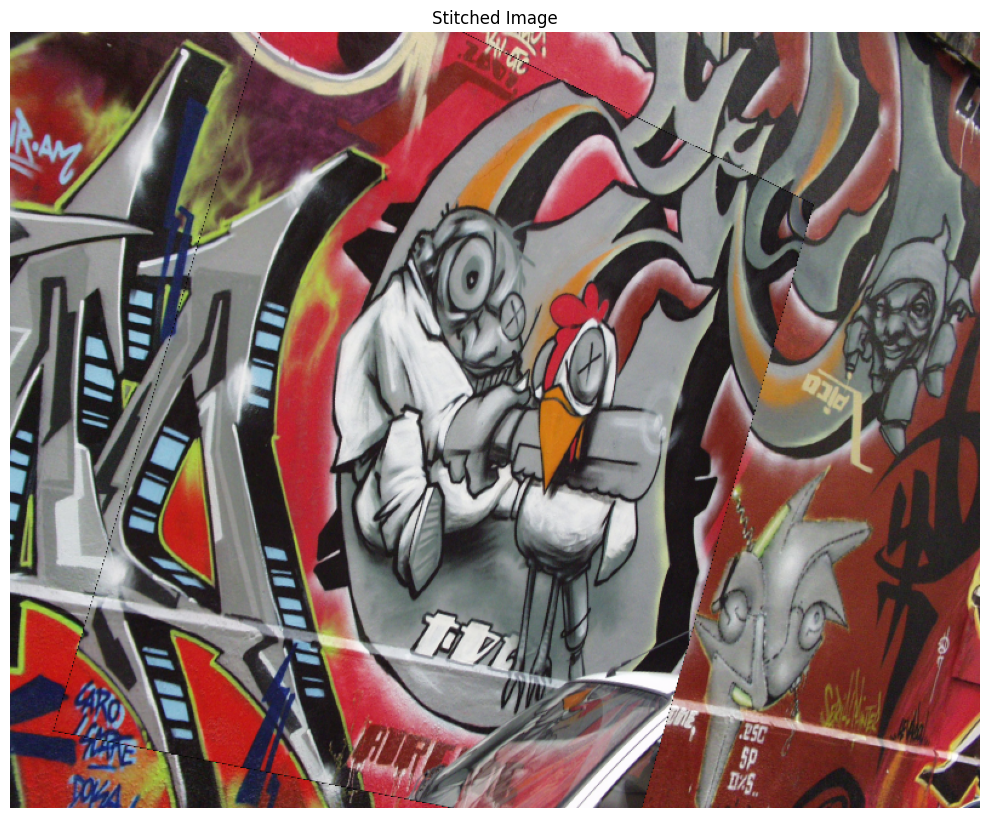

In [ ]:
final_transformed_image = transform.warp(img1, final_transform.inverse)
final_transformed_image = (final_transformed_image * 255).astype(np.uint8)
mask = (final_transformed_image == 0)
stitched_image = mask * img5 + final_transformed_image

plt.figure(figsize = (10, 10))
plt.imshow(stitched_image)
plt.title("Stitched Image")
plt.axis('off')
plt.tight_layout()